In [ ]:
!pip install neattext
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 1.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 897.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.7 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=8171dcdb0a1186c5fb62f8f8b2141fe95cf99c7e07c69cbfb787033baed5f34a
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3

In [ ]:
#clean text, wouldnt let me run without this, before the text was just one string
#could possible split it into just strings instead of procescing text not sure best way to go
#about this still thinking for now lol
import pandas as pd
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import preprocess_string
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pickle
import nltk 
import seaborn as sns
import neattext as nfx
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

plt.style.use('ggplot')
nltk.download('stopwords')

drive.mount('/content/drive')
results_df = pd.read_csv('/content/drive/MyDrive/SoCal Hackathon/useful.csv')

#filter to positive reviews from similar businesses only here, need to know what the sentiment column will be
#results_df = results_df[results_df]

results_df['text'] = results_df['text'].apply(nfx.remove_stopwords)
results_df['text'] = results_df['text'].apply(nfx.remove_punctuations)
results_df['text'] = results_df['text'].str.lower()

results_df['cleaned_text'] = results_df['text'].apply(preprocess_text)


def preprocess_text(text):
    return preprocess_string(text)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: ignored

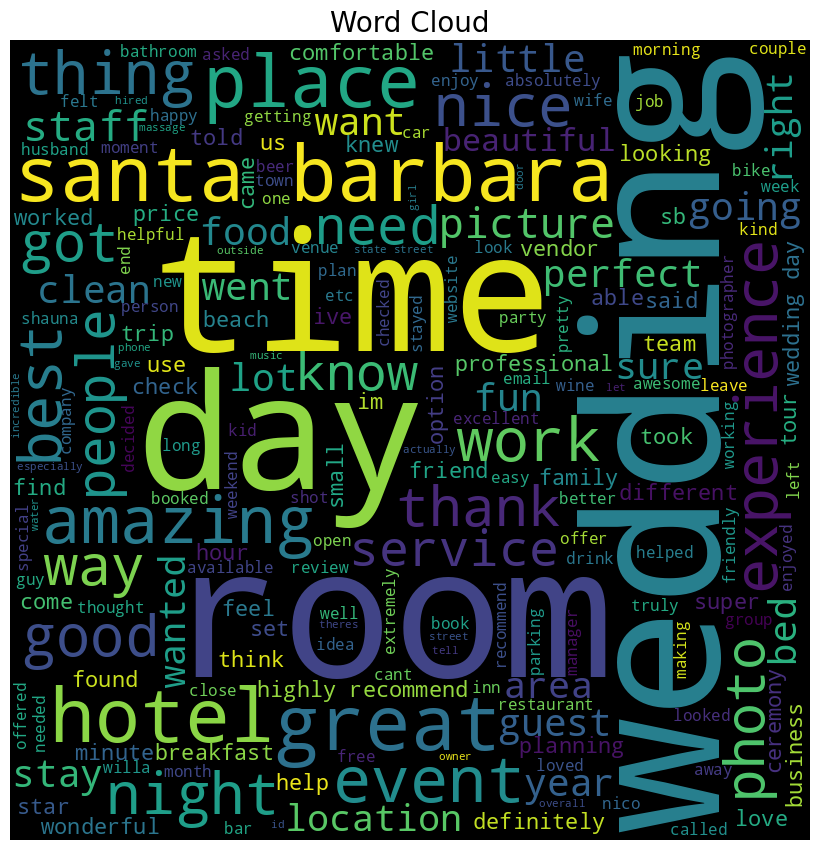

In [14]:
from wordcloud import WordCloud

def generate_wordcloud(df):
    text = " ".join(review for review in results_df["text"])
    wordcloud = WordCloud(width=800, height=800, min_font_size=10).generate(text)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.title("Word Cloud", fontsize=20)

    plt.show()

generate_wordcloud(results_df)

In [15]:
#need to create our dictionary and bow corpus to prepare model for LDA
texts = results_df['cleaned_text']
dic = corpora.Dictionary(texts)
corpus = [dic.doc2bow(doc) for doc in results_df['cleaned_text']]

KeyError: ignored

In [ ]:
## find optimal # of topics
## Takes awhile to run
coherence_scores = []
num_topics_range = range(2, 10)  # Check for number of topics from 2 to 20

for num_topics in num_topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=dic, num_topics=num_topics, passes=10, alpha='auto', per_word_topics=True, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dic, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

# Plot coherence scores
plt.plot(num_topics_range, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores vs. Number of Topics')
plt.show()

# Find the optimal number of topics
optimal_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]
print(f"Optimal number of topics: {optimal_num_topics}")

In [ ]:
#lda model parameters here, could modify these, for now i think 12 is ok
lda_model = LdaModel(corpus=corpus,
                     id2word=dic,
                     num_topics=5,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

In [ ]:
#print topics and the words in each
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
# 1 - flight cancellations
# 2 = Customer service - call centre
# 3 - flight & boarding
# 4 - custiomer service cabin crew
# 5 - website
# 6 - credit card miles


In [ ]:
!pip install pyldavis

In [ ]:
import pyLDAvis.gensim_models

#create the LDA viz, save it, display it, etc
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dic)
pyLDAvis.save_html(vis, 'lda_topics.html')
pyLDAvis.display(vis)

In [ ]:
#might change when we filter down to positive only
#topic 1 - hotel stay and surrounding things to do 
#topic 2 - wedding
#topic 3 - travel
#topic 4 - things to do
#topic 5 - services and catering

In [ ]:
#empty topic list to add from using a loop
assigned_topics = []

#assign topics to each row
for doc in corpus:
    doc_topics = lda_model.get_document_topics(doc)
    top_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0]
    assigned_topics.append((top_topic[0], top_topic[1]))

#add the assigned topics and scores to the results_df dataframe
results_df['assigned_topic_id'] = [t[0] for t in assigned_topics]
results_df['assigned_topic_score'] = [t[1] for t in assigned_topics]

In [ ]:
#group results df
grouped_results = results_df.groupby(['name', 'assigned_topic_id']).size().reset_index(name='count')
import seaborn as sns
import plotly.express as px


#barplot for topics by airline use for loop to create sep graphs for each airline
'''for name in results_df['name'].unique():
    temp_df = grouped_results[grouped_results['name']==name]
    plt.figure(figsize=(10,6))
    sns.barplot(x='assigned_topic_id', y='count', data=temp_df)
    plt.title(f"Topic by {name}")
    plt.xlabel("Topic")
    plt.ylabel("Count")
    plt.show()'''

fig = px.bar(grouped_results, x='assigned_topic_id', y='count', color="name", barmode="stack")
fig.show()

In [ ]:
import pandas as pd
import numpy as np
import nltk 
import seaborn as sns
import matplotlib.pyplot as plt
import neattext as nfx
import nltk
from nltk.corpus import stopwords
plt.style.use('ggplot')
nltk.download('stopwords')

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
from wordcloud import WordCloud
df = pd.read_csv('/content/drive/MyDrive/SoCal Hackathon/useful.csv')

In [18]:
df.head(5)

,Unnamed: 0,Professional Services,Event Planning & Services,Hotels,Hotels & Travel,business_id,relevance,review_id,stars.x,useful,funny,cool,text,date,name,city,stars.y,review_count,categories
0,1,0,1,0,0,_VFFzHb5eFYKdinYf_0GPQ,1,7CCq2pSKszMSB6wHCxTOsA,5,2,0,0,Stan is wonderful. I recently got married in S...,2009-09-09 21:38:31,Stanton's Gourmet Catering,Santa Barbara,5.0,11,"Event Planning & Services, Caterers"
1,2,0,1,0,0,_VFFzHb5eFYKdinYf_0GPQ,1,N_jOKGN6ujwFTOMkpqMEWA,5,1,0,0,Stanton's Gourmet Catering KNOCKED IT OUT OF T...,2016-07-27 22:59:30,Stanton's Gourmet Catering,Santa Barbara,5.0,11,"Event Planning & Services, Caterers"
2,3,0,1,0,0,_VFFzHb5eFYKdinYf_0GPQ,1,QtksP_K0914CQahk8SnEoA,5,1,0,0,5 stars isn't enough for Stanton!!!! Stanton p...,2018-08-29 17:08:36,Stanton's Gourmet Catering,Santa Barbara,5.0,11,"Event Planning & Services, Caterers"
3,4,0,1,0,0,_VFFzHb5eFYKdinYf_0GPQ,1,CKOMpA258C-FVZxNLXZcrQ,5,1,0,0,They make the best food!!!! They catered my fr...,2017-02-05 15:02:37,Stanton's Gourmet Catering,Santa Barbara,5.0,11,"Event Planning & Services, Caterers"
4,5,0,1,0,0,_VFFzHb5eFYKdinYf_0GPQ,1,2GxtmLyY_vN0Y3X9TOlw9A,5,0,0,0,We were completely blown away by Stanton's Gou...,2014-07-16 21:25:38,Stanton's Gourmet Catering,Santa Barbara,5.0,11,"Event Planning & Services, Caterers"


In [19]:
df['text'] = df['text'].apply(nfx.remove_stopwords)
df['text'] = df['text'].apply(nfx.remove_userhandles)
df['text'] = df['text'].apply(nfx.remove_punctuations)
df['text'] = df['text'].apply(nfx.remove_emojis)
df['text'] = df['text'].apply(nfx.remove_hashtags)
df['text'] = df['text'].str.lower()

In [ ]:
# Define the word to remove
word_to_remove = 'wedding'

# Replace the word with an empty string
df['text'] = df['text'].str.replace(word_to_remove, '')


In [25]:
# Define the word to remove
word_to_remove = 'day'

# Replace the word with an empty string
df['text'] = df['text'].str.replace(word_to_remove, '')

In [26]:
# Define the word to remove
word_to_remove = 'wedding'

# Replace the word with an empty string
df['text'] = df['text'].str.replace(word_to_remove, '')

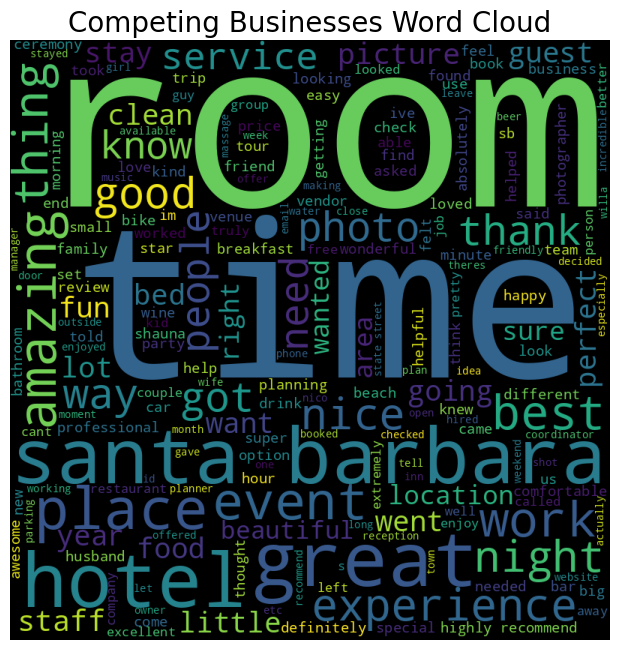

In [28]:
def generate_wordcloud(df, biz):
    text = " ".join(review for review in df["text"])
    wordcloud = WordCloud(width=800, height=800, min_font_size=10).generate(text)

    plt.figure(figsize=(6, 6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.title(f"{biz} Word Cloud", fontsize=20)

    plt.show()

generate_wordcloud(df, 'Competing Businesses' )

## We assign sentiment labels of positive negative and neutral to the reviews 


In [29]:
# make a copy 
df1 = df

In [30]:
df1['sentiment'] = df1['stars.x'].apply(lambda x: 'positive' if x > 3 else 'negative' if x < 3 else 'neutral')

In [ ]:
df1

<Axes: >

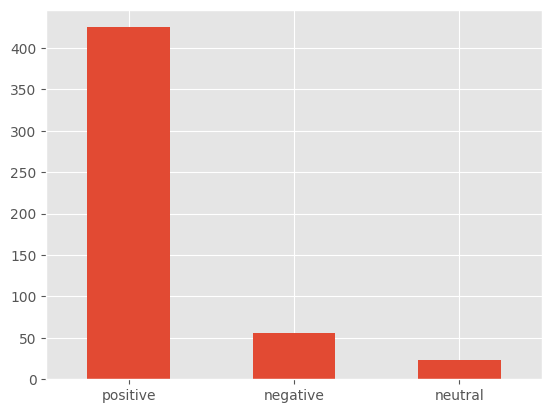

In [31]:
sentiment_counts = df1['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', rot=0)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [33]:
# Define target and variables
target = df1['sentiment']
text = df1['text']

In [34]:
# Vectorize and Transform
tf = TfidfVectorizer()
text = tf.fit_transform(text)

In [35]:
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size = .2, stratify=target)

In [36]:
# Naive Bayes 
nv = MultinomialNB()
nv.fit(X_train, y_train)

MultinomialNB()

In [37]:
nv.score(X_test, y_test)

0.8415841584158416

In [38]:
# Logistic Regression
lr = LogisticRegression(max_iter = 5000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [39]:
lr.score(X_test, y_test)



0.8415841584158416

In [41]:
!pip install -U sentence-transformers

## Try with transformers instead of Vectorizor
from sentence_transformers import SentenceTransformer
df2 = df
df2.reset_index(inplace=True, drop=False)
df2.rename(columns={'index': 'ID'}, inplace=True)
target = df2['sentiment']
text = df2['text']

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(text)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, target, test_size = .2, stratify=target)

In [43]:
# Logistic Regression
lr = LogisticRegression(max_iter = 5000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [44]:
lr.score(X_test, y_test)

0.8910891089108911

## We use vader to assign a score to each review for positive negative and neutral

In [45]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [46]:
from tqdm import tqdm

In [47]:
res = {}
for i, row in tqdm(df1.iterrows(), total=len(df1)):
    try:
        text = row['text']
        myid = row['review_id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        res[myid] = vader_result_rename
    except RuntimeError:
        print(f'Broke for id {myid}')

100%|██████████| 504/504 [00:00<00:00, 797.47it/s]


In [48]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'review_id'})
results_df = results_df.merge(df1, how='left')

In [49]:
results_df.columns

Index(['review_id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'ID', 'ID', 'Unnamed: 0', 'Professional Services',
       'Event Planning & Services', 'Hotels', 'Hotels & Travel', 'business_id',
       'relevance', 'stars.x', 'useful', 'funny', 'cool', 'text', 'date',
       'name', 'city', 'stars.y', 'review_count', 'categories', 'sentiment'],
      dtype='object')

In [50]:
results_df

,review_id,vader_neg,vader_neu,vader_pos,vader_compound,ID,ID,Unnamed: 0,Professional Services,Event Planning & Services,...,funny,cool,text,date,name,city,stars.y,review_count,categories,sentiment
0,7CCq2pSKszMSB6wHCxTOsA,0.000,0.436,0.564,0.9607,0,0,1,0,1,...,0,0,stan wonderful recently got married santa barb...,2009-09-09 21:38:31,Stanton's Gourmet Catering,Santa Barbara,5.0,11,"Event Planning & Services, Caterers",positive
1,N_jOKGN6ujwFTOMkpqMEWA,0.026,0.752,0.222,0.9541,1,1,2,0,1,...,0,0,stantons gourmet catering knocked park event s...,2016-07-27 22:59:30,Stanton's Gourmet Catering,Santa Barbara,5.0,11,"Event Planning & Services, Caterers",positive
2,QtksP_K0914CQahk8SnEoA,0.015,0.623,0.362,0.9876,2,2,3,0,1,...,0,0,5 stars stanton stanton provided catering hus...,2018-08-29 17:08:36,Stanton's Gourmet Catering,Santa Barbara,5.0,11,"Event Planning & Services, Caterers",positive
3,CKOMpA258C-FVZxNLXZcrQ,0.000,0.214,0.786,0.9001,3,3,4,0,1,...,0,0,best food catered friends professional delicious,2017-02-05 15:02:37,Stanton's Gourmet Catering,Santa Barbara,5.0,11,"Event Planning & Services, Caterers",positive
4,2GxtmLyY_vN0Y3X9TOlw9A,0.044,0.584,0.373,0.9865,4,4,5,0,1,...,0,0,completely blown away stantons gourmet caterin...,2014-07-16 21:25:38,Stanton's Gourmet Catering,Santa Barbara,5.0,11,"Event Planning & Services, Caterers",positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,ux-PbXNkYbKz_MzQ9dNwLA,0.025,0.620,0.355,0.9812,499,499,500,0,1,...,0,0,absolutely best vacation ebike way enjoy santa...,2014-06-21 20:12:39,E-bike Santa Barbara,Santa Barbara,5.0,69,"Event Planning & Services, Local Services, Bik...",positive
500,SxmnMlqie3vOxoZfh8YfJg,0.046,0.697,0.257,0.9855,500,500,501,0,1,...,0,1,memorable affordable importantly enjoyable exp...,2015-05-05 21:00:07,E-bike Santa Barbara,Santa Barbara,5.0,69,"Event Planning & Services, Local Services, Bik...",positive
501,2VWh9xAOp20ccP-R5na1nw,0.024,0.563,0.413,0.9881,501,501,502,0,1,...,0,1,5 stars ebike sb karen owner amazing laid tell...,2019-01-22 05:27:32,E-bike Santa Barbara,Santa Barbara,5.0,69,"Event Planning & Services, Local Services, Bik...",positive
502,w3vnl1yyak_l6ptf7LCC-A,0.037,0.599,0.364,0.9652,502,502,503,0,1,...,0,0,ebike way santa barbara renting karen makes ex...,2014-10-12 04:55:19,E-bike Santa Barbara,Santa Barbara,5.0,69,"Event Planning & Services, Local Services, Bik...",positive


## We classify the emotions of the eviews and look at the emtions over the years


In [51]:
pip install NRCLex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43327 sha256=328a9a5e1f82bf799c9db74f5bfe712ee03d5943164dc1aea79c2c6388a9e1e8
  Stored in directory: /root/.cache/pip/wheels/68/c4/f2/c390dd3eac398fdf45f7a01c6516bc53fa7a9ab59c7d2ff518
Successfully built NRCLex


In [52]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [53]:
from nrclex import NRCLex
str_review = ",".join(results_df["text"])
text_object = NRCLex(str_review)

In [54]:
data = text_object.raw_emotion_scores
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)
import plotly.express as px
fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

In [55]:
from datetime import datetime

results_df['year'] = results_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y'))

results_df

,review_id,vader_neg,vader_neu,vader_pos,vader_compound,ID,ID,Unnamed: 0,Professional Services,Event Planning & Services,...,cool,text,date,name,city,stars.y,review_count,categories,sentiment,year
0,7CCq2pSKszMSB6wHCxTOsA,0.000,0.436,0.564,0.9607,0,0,1,0,1,...,0,stan wonderful recently got married santa barb...,2009-09-09 21:38:31,Stanton's Gourmet Catering,Santa Barbara,5.0,11,"Event Planning & Services, Caterers",positive,2009
1,N_jOKGN6ujwFTOMkpqMEWA,0.026,0.752,0.222,0.9541,1,1,2,0,1,...,0,stantons gourmet catering knocked park event s...,2016-07-27 22:59:30,Stanton's Gourmet Catering,Santa Barbara,5.0,11,"Event Planning & Services, Caterers",positive,2016
2,QtksP_K0914CQahk8SnEoA,0.015,0.623,0.362,0.9876,2,2,3,0,1,...,0,5 stars stanton stanton provided catering hus...,2018-08-29 17:08:36,Stanton's Gourmet Catering,Santa Barbara,5.0,11,"Event Planning & Services, Caterers",positive,2018
3,CKOMpA258C-FVZxNLXZcrQ,0.000,0.214,0.786,0.9001,3,3,4,0,1,...,0,best food catered friends professional delicious,2017-02-05 15:02:37,Stanton's Gourmet Catering,Santa Barbara,5.0,11,"Event Planning & Services, Caterers",positive,2017
4,2GxtmLyY_vN0Y3X9TOlw9A,0.044,0.584,0.373,0.9865,4,4,5,0,1,...,0,completely blown away stantons gourmet caterin...,2014-07-16 21:25:38,Stanton's Gourmet Catering,Santa Barbara,5.0,11,"Event Planning & Services, Caterers",positive,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,ux-PbXNkYbKz_MzQ9dNwLA,0.025,0.620,0.355,0.9812,499,499,500,0,1,...,0,absolutely best vacation ebike way enjoy santa...,2014-06-21 20:12:39,E-bike Santa Barbara,Santa Barbara,5.0,69,"Event Planning & Services, Local Services, Bik...",positive,2014
500,SxmnMlqie3vOxoZfh8YfJg,0.046,0.697,0.257,0.9855,500,500,501,0,1,...,1,memorable affordable importantly enjoyable exp...,2015-05-05 21:00:07,E-bike Santa Barbara,Santa Barbara,5.0,69,"Event Planning & Services, Local Services, Bik...",positive,2015
501,2VWh9xAOp20ccP-R5na1nw,0.024,0.563,0.413,0.9881,501,501,502,0,1,...,1,5 stars ebike sb karen owner amazing laid tell...,2019-01-22 05:27:32,E-bike Santa Barbara,Santa Barbara,5.0,69,"Event Planning & Services, Local Services, Bik...",positive,2019
502,w3vnl1yyak_l6ptf7LCC-A,0.037,0.599,0.364,0.9652,502,502,503,0,1,...,0,ebike way santa barbara renting karen makes ex...,2014-10-12 04:55:19,E-bike Santa Barbara,Santa Barbara,5.0,69,"Event Planning & Services, Local Services, Bik...",positive,2014


In [ ]:
df_2013 = results_df[results_df['year'] == '2013']

str_review = ",".join(df_2013["text"])
text_object = NRCLex(str_review)
data = text_object.raw_emotion_scores
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)
import plotly.express as px
fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

In [ ]:
df_2014 = results_df[results_df['year'] == '2014']

str_review = ",".join(df_2014["text"])
text_object = NRCLex(str_review)
data = text_object.raw_emotion_scores
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)
import plotly.express as px
fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

In [ ]:
df_2015 = results_df[results_df['year'] == '2015']

str_review = ",".join(df_2015["text"])
text_object = NRCLex(str_review)
data = text_object.raw_emotion_scores
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)
import plotly.express as px
fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

In [ ]:
df_2016 = results_df[results_df['year'] == '2016']

str_review = ",".join(df_2016["text"])
text_object = NRCLex(str_review)
data = text_object.raw_emotion_scores
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)
import plotly.express as px
fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

In [ ]:
df_2017 = results_df[results_df['year'] == '2017']

str_review = ",".join(df_2017["text"])
text_object = NRCLex(str_review)
data = text_object.raw_emotion_scores
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)
import plotly.express as px
fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

In [ ]:
df_2018 = results_df[results_df['year'] == '2018']

str_review = ",".join(df_2018["text"])
text_object = NRCLex(str_review)
data = text_object.raw_emotion_scores
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)
import plotly.express as px
fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

In [ ]:
df_2019 = results_df[results_df['year'] == '2019']

str_review = ",".join(df_2019["text"])
text_object = NRCLex(str_review)
data = text_object.raw_emotion_scores
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)
import plotly.express as px
fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

In [ ]:
df_2020 = results_df[results_df['year'] == '2020']

str_review = ",".join(df_2020["text"])
text_object = NRCLex(str_review)
data = text_object.raw_emotion_scores
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)
import plotly.express as px
fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

In [ ]:
df_2021 = results_df[results_df['year'] == '2021']

str_review = ",".join(df_2021["text"])
text_object = NRCLex(str_review)
data = text_object.raw_emotion_scores
emotion_df = pd.DataFrame.from_dict(data, orient='index')
emotion_df = emotion_df.reset_index()
emotion_df = emotion_df.rename(columns={'index' : 'Emotion Classification' , 0: 'Emotion Count'})
emotion_df = emotion_df.sort_values(by=['Emotion Count'], ascending=False)
import plotly.express as px
fig = px.bar(emotion_df, x='Emotion Count', y='Emotion Classification', color = 'Emotion Classification', orientation='h', width = 800, height = 400)
fig.show()

In [ ]:
results_df['year'].value_counts()

In [56]:
for index, row in results_df.iterrows():
    text = row['text']
    text_object = NRCLex(text)
    emotions = text_object.affect_frequencies
    max_emotion = max(emotions, key=emotions.get)
    results_df.at[index, 'emotion_classification'] = max_emotion

In [57]:
# save the df 
results_df.to_csv('yelp_results.csv', index = False)

In [58]:
results_df = pd.read_csv('yelp_results.csv')

In [59]:
#!pip install --upgrade gensim
#!pip install pyldavis
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import preprocess_string

In [60]:
results_df.columns

Index(['review_id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'ID', 'ID.1', 'Unnamed: 0', 'Professional Services',
       'Event Planning & Services', 'Hotels', 'Hotels & Travel', 'business_id',
       'relevance', 'stars.x', 'useful', 'funny', 'cool', 'text', 'date',
       'name', 'city', 'stars.y', 'review_count', 'categories', 'sentiment',
       'year', 'emotion_classification'],
      dtype='object')

## Topic Modelling

In [61]:
def preprocess_text(text):
    return preprocess_string(text)

results_df['cleaned_text'] = results_df['text'].apply(preprocess_text)



In [62]:
#need to create our dictionary and bow corpus to prepare model for LDA
texts = results_df['cleaned_text']
dic = corpora.Dictionary(texts)
corpus = [dic.doc2bow(doc) for doc in results_df['cleaned_text']]

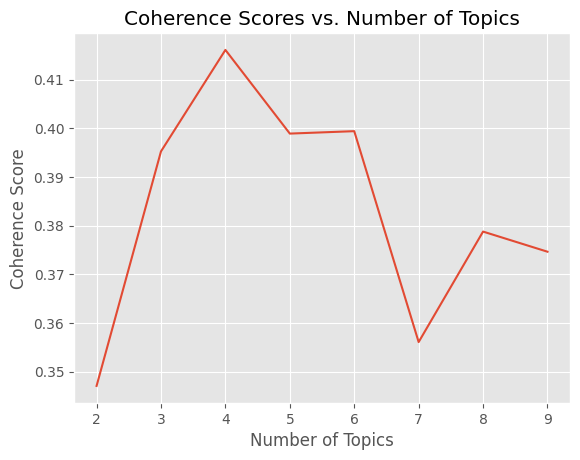

Optimal number of topics: 4


In [63]:
## find optimal # of topics
coherence_scores = []
num_topics_range = range(2, 10)  # Check for number of topics from 2 to 20

for num_topics in num_topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=dic, num_topics=num_topics, passes=10, alpha='auto', per_word_topics=True, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dic, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

# Plot coherence scores
plt.plot(num_topics_range, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores vs. Number of Topics')
plt.show()

# Find the optimal number of topics
optimal_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]
print(f"Optimal number of topics: {optimal_num_topics}")

In [64]:
#lda model parameters here, could modify these
lda_model = LdaModel(corpus=corpus,
                     id2word=dic,
                     num_topics=4,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

In [65]:
#print topics and the words in each
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.018*"room" + 0.007*"like" + 0.006*"night" + 0.006*"stai" + 0.005*"hotel" + 0.005*"staff" + 0.004*"bed" + 0.004*"piano" + 0.004*"great" + 0.004*"told"
Topic: 1 
Words: 0.014*"work" + 0.012*"photo" + 0.010*"great" + 0.008*"time" + 0.008*"recommend" + 0.007*"amaz" + 0.007*"want" + 0.007*"famili" + 0.007*"event" + 0.007*"love"
Topic: 2 
Words: 0.009*"help" + 0.009*"wine" + 0.009*"recommend" + 0.008*"time" + 0.008*"santa" + 0.008*"tour" + 0.008*"event" + 0.007*"plan" + 0.007*"barbara" + 0.006*"great"
Topic: 3 
Words: 0.016*"room" + 0.014*"hotel" + 0.010*"stai" + 0.010*"place" + 0.007*"santa" + 0.007*"locat" + 0.007*"nice" + 0.007*"barbara" + 0.006*"clean" + 0.006*"time"


In [66]:
!pip install pyLDAvis
import pyLDAvis.gensim_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.7 MB/s eta 0:00:00


In [67]:
#create the LDA viz, save it, display it, etc
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dic)
pyLDAvis.save_html(vis, 'lda_topics.html')
pyLDAvis.display(vis)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [68]:
#empty topic list to add from using a loop
assigned_topics = []

#assign topics to each row
for doc in corpus:
    doc_topics = lda_model.get_document_topics(doc)
    top_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0]
    assigned_topics.append((top_topic[0], top_topic[1]))

#add the assigned topics and scores to the results_df dataframe
results_df['assigned_topic_id'] = [t[0] for t in assigned_topics]
results_df['assigned_topic_score'] = [t[1] for t in assigned_topics]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [69]:
results_df.columns

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Index(['review_id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'ID', 'ID.1', 'Unnamed: 0', 'Professional Services',
       'Event Planning & Services', 'Hotels', 'Hotels & Travel', 'business_id',
       'relevance', 'stars.x', 'useful', 'funny', 'cool', 'text', 'date',
       'name', 'city', 'stars.y', 'review_count', 'categories', 'sentiment',
       'year', 'emotion_classification', 'cleaned_text', 'assigned_topic_id',
       'assigned_topic_score'],
      dtype='object')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



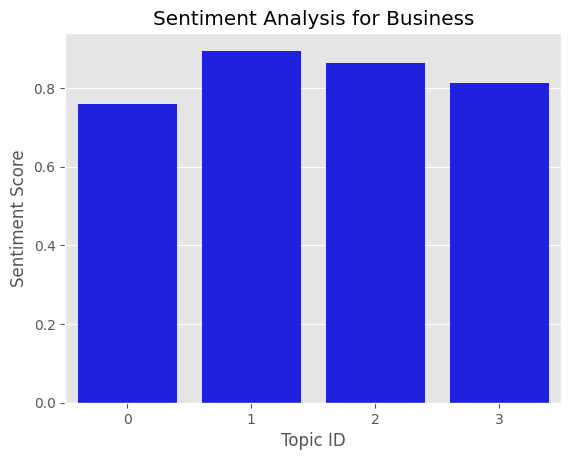

In [70]:
# Compute the average compound sentiment score for each topic for the filtered dataframe
average_sentiment = results_df.groupby('assigned_topic_id')['vader_compound'].mean().reset_index()

# Plot a bar chart with the topic IDs on the x-axis and the sentiment scores on the y-axis
average_sentiment

sns.barplot(x='assigned_topic_id', y='vader_compound', data=average_sentiment, color='blue')
plt.xlabel('Topic ID')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis for Business')
plt.show()

## We Pick two topics (dimensions) and create a perception map of how all the businesses are located on the two-dimensional map. The axes go from -1 to 1, where 1 denotes that all the reviews pertinent to an airline about that topic are positive, whereas -1 denotes that all tweets are negative

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



KeyError: ignored

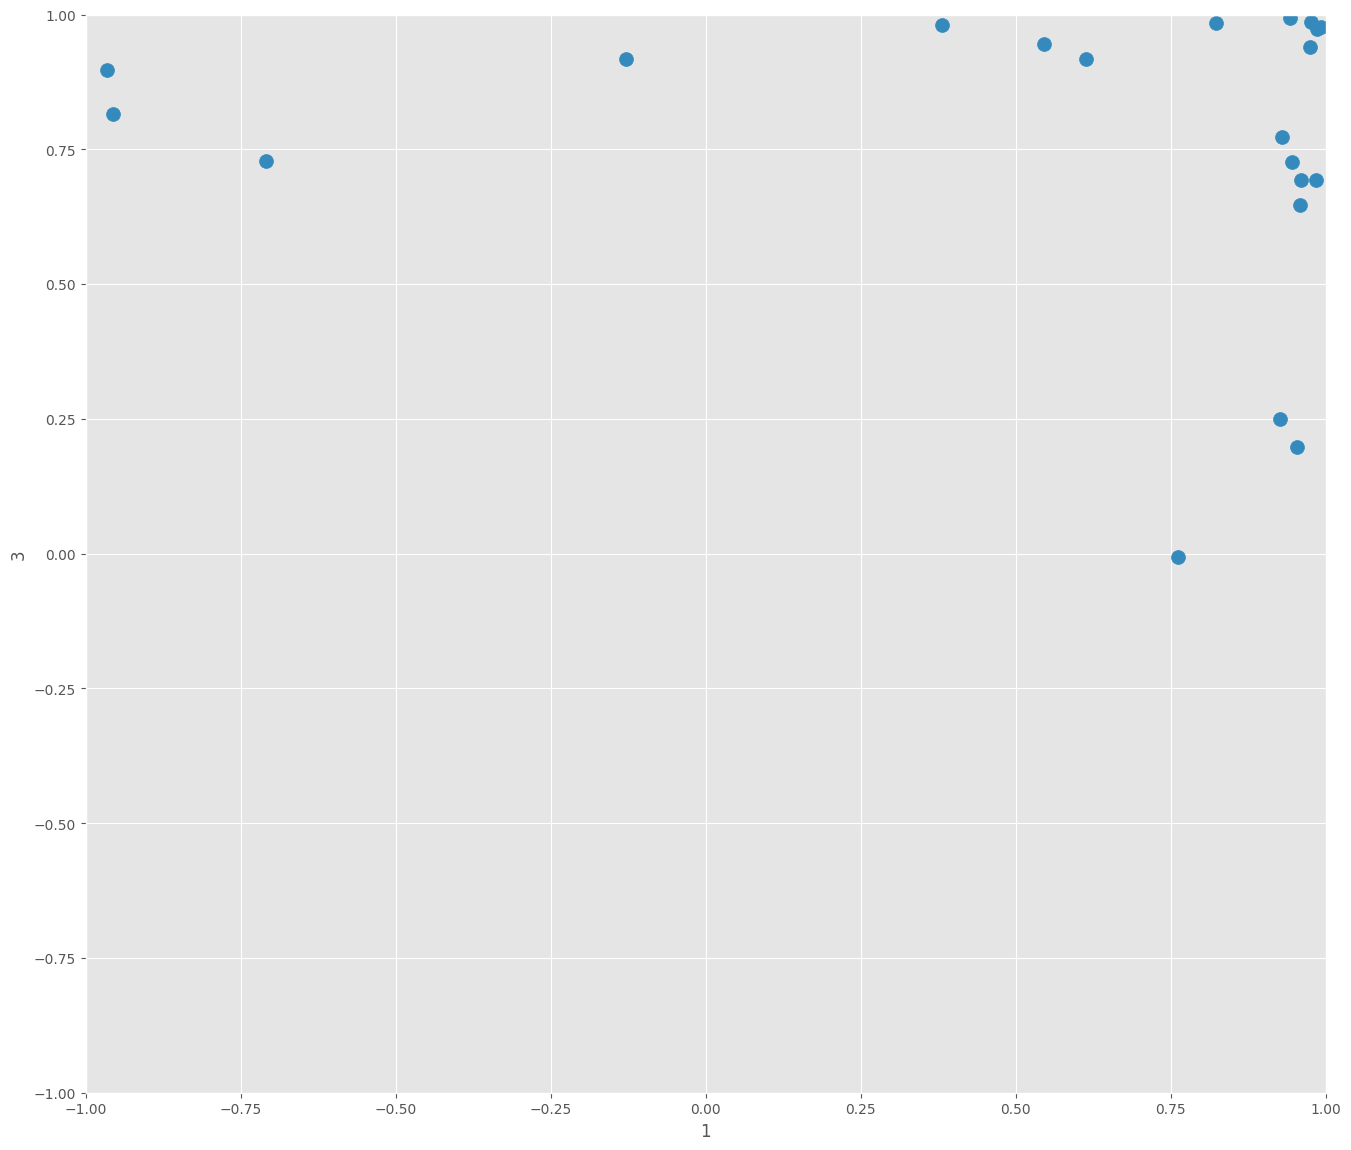

In [76]:
# Filtering the dataframe
filtered_df = results_df[(results_df['assigned_topic_id'] == 1) | (results_df['assigned_topic_id'] == 3)]

# Compute average compound sentiment score for each airline-topic combination
average_sentiment = filtered_df.groupby(['business_id', 'assigned_topic_id'])['vader_compound'].mean().reset_index()

# Normalize sentiment scores to a range of -1 to 1
average_sentiment['normalized_sentiment'] = average_sentiment['vader_compound'].apply(lambda x: max(min(x, 1), -1))

# Pivot the dataframe to have topics as columns
pivoted_df = average_sentiment.pivot_table(index='business_id', columns='assigned_topic_id', values='normalized_sentiment').reset_index()

# Plot the perception map
fig, ax = plt.subplots(figsize = (16,14))
pivoted_df.plot.scatter(x=1, y=3, ax=ax, s=100, xlim=(-1, 1), ylim=(-1, 1))

# Label the points with the airline names
for i, row in pivoted_df.iterrows():
    ax.text(row[1], row[4], row['business_id'], fontsize=10, horizontalalignment='left', verticalalignment='bottom')

ax.set_xlabel('Topic 2 Sentiment Score')
ax.set_ylabel('Topic 3 Sentiment Score')
ax.set_title('Perception Map for Topics 2 and 3')
ax.grid(True, linestyle='--')
plt.show()